In [369]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.signal import savgol_filter
from fancyimpute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

In [370]:
gen1_train = pd.read_csv('../data/gen1_train_comp_final.csv')
gen2_train = pd.read_csv('../data/gen2_train_comp_final.csv')
gen1_test = pd.read_csv('../data/gen1_test_comp_final.csv')
gen2_test = pd.read_csv('../data/gen2_test_upto9_comp_final.csv')

# Goals
1. Use the training set to learn how parent growth patterns and early child growth (ages 0-9) relate to later child growth (ages 10-18)
2. Apply to the test set, where you only have parent data and early child data (0-9), to predict the later child growth (10-18)

Note:
* No Ground Truth for age 17, so no need to predict those ages

In [372]:
def plot_age_distribution(gen1_train, gen2_train):
    plt.figure(figsize=(12, 6))
    plt.hist(gen1_train["age"], bins=30, alpha=0.5, color="blue", label="Gen1 Age Distribution")
    plt.hist(gen2_train["AgeGr"], bins=30, alpha=0.5, color="red", label="Gen2 Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.title("Age Distribution: Gen1 vs Gen2")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.savefig(f"./viz/age_distro", bbox_inches='tight')

    plt.show()

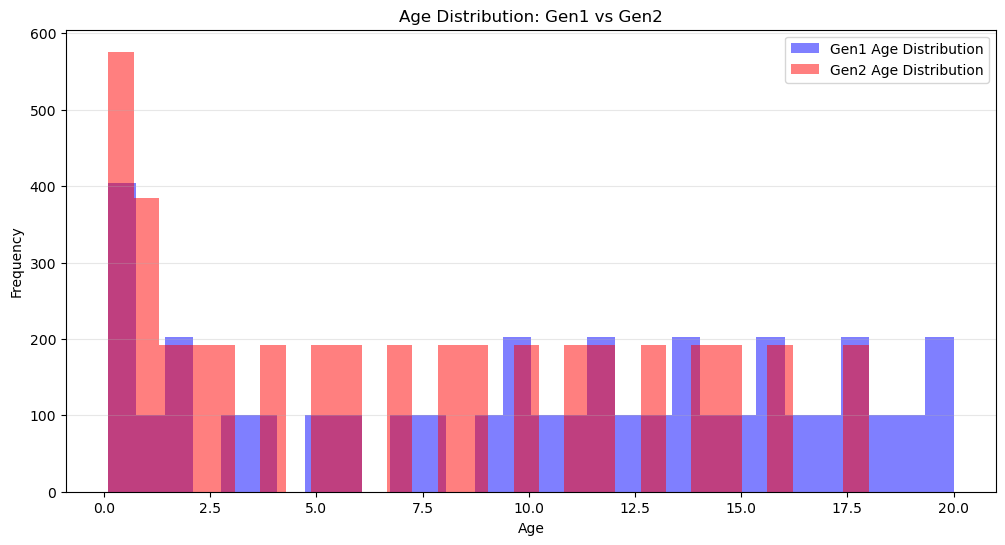

In [373]:
plot_age_distribution(gen1_train, gen2_train)

In [374]:
gen1_train['age'].describe()

count    3636.000000
mean       10.350000
std         6.324272
min         0.100000
25%         4.750000
50%        11.250000
75%        15.625000
max        20.000000
Name: age, dtype: float64

In [375]:
gen2_train['AgeGr'].describe()

count    4224.000000
mean        7.140909
std         5.646657
min         0.100000
25%         1.500000
50%         6.500000
75%        12.000000
max        18.000000
Name: AgeGr, dtype: float64

# Cleaning

In [377]:
def clean_and_interpolate_heights(gen1_data, age_col='age'):
    """Clean and interpolate height measurements for Gen1 data."""
    data_clean = gen1_data.sort_values(['gen1_id', age_col])
    
    data_clean['SHgt_cm_orig'] = data_clean['SHgt_cm'] # store original heights
    
    data_clean['SHgt_cm'] = data_clean.groupby('gen1_id')['SHgt_cm'].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
    
    return data_clean

def clean_and_interpolate_gen2(gen2_data):
    """Clean and interpolate height and weight measurements for Gen2 data."""
    data_clean = gen2_data.sort_values(['gen2_id', 'AgeGr'])
    
    data_clean['SHgt_cm_orig'] = data_clean['SHgt_cm']
    if 'Wgt_kg' in data_clean.columns:
        data_clean['Wgt_kg_orig'] = data_clean['Wgt_kg']
    
    data_clean['SHgt_cm'] = data_clean.groupby('gen2_id')['SHgt_cm'].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
    
    if 'Wgt_kg' in data_clean.columns:
        data_clean['Wgt_kg'] = data_clean.groupby('gen2_id')['Wgt_kg'].transform(
            lambda x: x.interpolate(method='linear', limit_direction='both')
        )
    
    return data_clean

In [378]:
parent_sex_map = gen1_train.groupby('gen1_id')['sex_assigned_at_birth'].first()
    

inconsistent_parents = gen2_train.groupby('gen2_id').agg({
    'study_parent_sex': lambda x: x.nunique(),
    'study_parent_id_new': 'first'
}).query('study_parent_sex > 1')

In [379]:
inconsistent_parents

,study_parent_sex,study_parent_id_new
gen2_id,,
1332,2,724
2505,2,668
2517,2,482
3012,2,636


In [380]:
gen2_train[gen2_train['study_parent_id_new']==668]

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
2178,2645,M,father,668,0.10,58.496880,NaN
2179,2645,M,father,668,0.25,64.448008,NaN
2180,2645,M,father,668,0.50,71.505477,NaN
2181,2645,M,father,668,0.75,76.405842,NaN
2182,2645,M,father,668,1.00,NaN,NaN
2183,2645,M,father,668,1.50,86.101788,NaN
2184,2645,M,father,668,2.00,NaN,NaN
2185,2645,M,father,668,3.00,100.068455,NaN
2186,2645,M,father,668,4.00,105.085901,NaN
2187,2645,M,father,668,5.00,111.420155,16.782017


In [381]:
gen2_train[gen2_train['gen2_id']==2505]

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
4136,2505,F,mother,668,0.10,58.894508,NaN
4137,2505,F,mother,668,0.25,62.822452,NaN
4138,2505,F,mother,668,0.50,68.207623,NaN
4139,2505,F,mother,668,0.75,72.622024,NaN
4140,2505,F,mother,668,1.00,78.192172,NaN
4141,2505,F,mother,668,1.50,85.216314,NaN
4142,2505,F,mother,668,2.00,91.741224,NaN
4143,2505,F,mother,668,3.00,100.252722,NaN
4144,2505,F,mother,668,4.00,105.917235,NaN
4145,2505,F,mother,668,5.00,111.278205,20.744253


In [382]:
def fix_parent_sex_inconsistencies(gen2_train, gen1_train):
    """Fix inconsistencies in parent sex records within gen2_train."""
    parent_sex_map = gen1_train.groupby('gen1_id')['sex_assigned_at_birth'].first()
    
    inconsistent_parents = gen2_train.groupby('gen2_id').agg({
        'study_parent_sex': lambda x: x.nunique(),
        'study_parent_id_new': 'first'
    }).query('study_parent_sex > 1')
    
    gen2_train_clean = gen2_train.copy()
    
    # Fix known cases (siblings or parents in gen1_train)
    # pattern: mother recorded first, then switches to father after age 6-7
    for idx in inconsistent_parents.index:
        subject_data = gen2_train[gen2_train['gen2_id'] == idx]
        parent_id = subject_data['study_parent_id_new'].iloc[0]
        
        # If parent exists in gen1 data, use that sex
        if parent_id in parent_sex_map:
            actual_sex = parent_sex_map[parent_id]
            correct_parent_sex = 'father' if actual_sex == 'M' else 'mother'
            gen2_train_clean.loc[gen2_train_clean['gen2_id'] == idx, 'study_parent_sex'] = correct_parent_sex
        else:
            # If not in gen1, use the most recent recording (after age 7)
            later_records = subject_data[subject_data['AgeGr'] >= 7.0]['study_parent_sex'].mode()
            if not later_records.empty:
                gen2_train_clean.loc[gen2_train_clean['gen2_id'] == idx, 'study_parent_sex'] = later_records.iloc[0]
    
    return gen2_train_clean

In [383]:
def clean_all_data(gen1_train, gen2_train, gen1_test, gen2_test):
    gen1_train_clean = clean_and_interpolate_heights(gen1_train)
    gen1_test_clean = clean_and_interpolate_heights(gen1_test)
    
    gen2_train_clean = fix_parent_sex_inconsistencies(gen2_train, gen1_train)
    
    gen2_train_clean = clean_and_interpolate_gen2(gen2_train_clean)
    gen2_test_clean = clean_and_interpolate_gen2(gen2_test)
    
    return gen1_train_clean, gen2_train_clean, gen1_test_clean, gen2_test_clean

In [384]:
gen1_train_clean, gen2_train_clean, gen1_test_clean, gen2_test_clean = clean_all_data(
    gen1_train, gen2_train, gen1_test, gen2_test
)

In [385]:
gen2_train_clean[gen2_train_clean['gen2_id']==1332]

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg,SHgt_cm_orig,Wgt_kg_orig
4202,1332,F,father,724,0.10,54.098866,18.839206,54.098866,NaN
4203,1332,F,father,724,0.25,59.128432,18.839206,59.128432,NaN
4204,1332,F,father,724,0.50,67.256015,18.839206,67.256015,NaN
4205,1332,F,father,724,0.75,72.511388,18.839206,72.511388,NaN
4206,1332,F,father,724,1.00,74.886310,18.839206,74.886310,NaN
4207,1332,F,father,724,1.50,85.617761,18.839206,85.617761,NaN
4208,1332,F,father,724,2.00,91.007144,18.839206,91.007144,NaN
4209,1332,F,father,724,3.00,99.977795,18.839206,99.977795,NaN
4210,1332,F,father,724,4.00,109.291388,18.839206,109.291388,NaN
4211,1332,F,father,724,5.00,114.288786,18.839206,114.288786,18.839206


In [386]:
inconsistent = gen2_train_clean.groupby('gen2_id').agg({
    'study_parent_sex': lambda x: x.nunique(),
    'study_parent_id_new': 'first'
}).query('study_parent_sex > 1')
inconsistent

,study_parent_sex,study_parent_id_new
gen2_id,,


In [387]:
gen2_train_clean['study_parent_sex'].value_counts()

study_parent_sex
father    2288
mother    1936
Name: count, dtype: int64

In [388]:
gen2_train_clean[gen2_train_clean['gen2_id'] == 2661]

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg,SHgt_cm_orig,Wgt_kg_orig
2002,2661,F,father,565,0.10,NaN,NaN,NaN,NaN
2003,2661,F,father,565,0.25,NaN,NaN,NaN,NaN
2004,2661,F,father,565,0.50,NaN,NaN,NaN,NaN
2005,2661,F,father,565,0.75,NaN,NaN,NaN,NaN
2006,2661,F,father,565,1.00,NaN,NaN,NaN,NaN
2007,2661,F,father,565,1.50,NaN,NaN,NaN,NaN
2008,2661,F,father,565,2.00,NaN,NaN,NaN,NaN
2009,2661,F,father,565,3.00,NaN,NaN,NaN,NaN
2010,2661,F,father,565,4.00,NaN,NaN,NaN,NaN
2011,2661,F,father,565,5.00,NaN,NaN,NaN,NaN


In [389]:
gen2_train_clean = gen2_train_clean[gen2_train_clean['gen2_id'] != 2661]

In [390]:
gen2_train_clean.isna().sum()

gen2_id                     0
sex_assigned_at_birth       0
study_parent_sex            0
study_parent_id_new         0
AgeGr                       0
SHgt_cm                     0
Wgt_kg                    198
SHgt_cm_orig              490
Wgt_kg_orig              2023
dtype: int64

In [391]:
gen2_test_clean.isna().sum()

gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                    0
Wgt_kg                    56
SHgt_cm_orig             132
Wgt_kg_orig              823
dtype: int64

In [392]:
gen1_train_clean.isna().sum()

gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                    0
SHgt_cm_orig             310
dtype: int64

In [393]:
gen1_test_clean.isna().sum()

gen1_id                    0
sex_assigned_at_birth      0
age                        0
SHgt_cm                    0
SHgt_cm_orig             216
dtype: int64

In [394]:
for df in [gen1_train_clean, gen1_test_clean, gen2_train_clean, gen2_test_clean]:
    if 'SHgt_cm_orig' in df.columns:
        df.drop('SHgt_cm_orig', axis=1, inplace=True)
    if 'Wgt_kg_orig' in df.columns:
        df.drop('Wgt_kg_orig', axis=1, inplace=True)

## Shared Parents in Train/Test

In [396]:
train_parents = set(gen2_train_clean['study_parent_id_new'].unique())
test_parents = set(gen2_test_clean['study_parent_id_new'].unique())
shared_parents = train_parents.intersection(test_parents)
len(shared_parents)

50

In [397]:
def analyze_shared_parents(gen2_train, gen2_test, gen1_train, gen1_test):
    train_parents = set(gen2_train['study_parent_id_new'].unique())
    test_parents = set(gen2_test['study_parent_id_new'].unique())
    shared_parents = train_parents.intersection(test_parents)
    
    results = {
        'shared_parents': shared_parents,
        'parent_details': []
    }
    
    for parent_id in shared_parents:
        # children data
        train_children = gen2_train[gen2_train['study_parent_id_new'] == parent_id]['gen2_id'].unique()
        test_children = gen2_test[gen2_test['study_parent_id_new'] == parent_id]['gen2_id'].unique()
        
        # parent data
        parent_train = gen1_train[gen1_train['gen1_id'] == parent_id]
        parent_test = gen1_test[gen1_test['gen1_id'] == parent_id]
        
        # calculate height differences
        common_ages = set(parent_train['age']).intersection(set(parent_test['age']))
        height_diffs = []
        
        for age in common_ages:
            train_height = parent_train[parent_train['age'] == age]['SHgt_cm'].iloc[0]
            test_height = parent_test[parent_test['age'] == age]['SHgt_cm'].iloc[0]
            height_diffs.append(abs(train_height - test_height))
        
        results['parent_details'].append({
            'parent_id': parent_id,
            'train_children': train_children,
            'test_children': test_children,
            'num_train_children': len(train_children),
            'num_test_children': len(test_children),
            'max_height_diff': max(height_diffs) if height_diffs else None,
            'mean_height_diff': sum(height_diffs)/len(height_diffs) if height_diffs else None
        })
    
    return results

In [398]:
def reconcile_parent_trajectories(gen1_train, gen1_test, shared_parents):
    """Reconcile height measurements for parents with children in both train and test."""
    gen1_train_reconciled = gen1_train.copy()
    gen1_test_reconciled = gen1_test.copy()
    
    for parent_id in shared_parents:
        train_data = gen1_train[gen1_train['gen1_id'] == parent_id]
        test_data = gen1_test[gen1_test['gen1_id'] == parent_id]
        
        merged = pd.merge(
            train_data[['age', 'SHgt_cm']], 
            test_data[['age', 'SHgt_cm']], 
            on='age', 
            suffixes=('_train', '_test')
        )
        
        # average heights
        merged['SHgt_cm_avg'] = merged[['SHgt_cm_train', 'SHgt_cm_test']].mean(axis=1)
        
        # update both datasets with the averaged heights
        for age, height in zip(merged['age'], merged['SHgt_cm_avg']):
            gen1_train_reconciled.loc[
                (gen1_train_reconciled['gen1_id'] == parent_id) & 
                (gen1_train_reconciled['age'] == age), 
                'SHgt_cm'
            ] = height
            
            gen1_test_reconciled.loc[
                (gen1_test_reconciled['gen1_id'] == parent_id) & 
                (gen1_test_reconciled['age'] == age), 
                'SHgt_cm'
            ] = height
    
    return gen1_train_reconciled, gen1_test_reconciled

In [399]:
shared_parent_analysis = analyze_shared_parents(gen2_train_clean, gen2_test_clean, gen1_train_clean, gen1_test_clean)

for parent_detail in shared_parent_analysis['parent_details'][:3]:
    print(f"\nParent {parent_detail['parent_id']}:")
    print(f"Children in train: {parent_detail['train_children']}")
    print(f"Children in test: {parent_detail['test_children']}")
    print(f"Max height difference: {parent_detail['max_height_diff']:.2f} cm")


Parent 768:
Children in train: [2816]
Children in test: [2772]
Max height difference: 1.16 cm

Parent 764:
Children in train: [2758]
Children in test: [2798]
Max height difference: 1.43 cm

Parent 525:
Children in train: [2560]
Children in test: [2607]
Max height difference: 1.20 cm


In [400]:
if shared_parent_analysis['shared_parents']:
    gen1_train_reconciled, gen1_test_reconciled = reconcile_parent_trajectories(
        gen1_train_clean, 
        gen1_test_clean, 
        shared_parent_analysis['shared_parents']
)

In [401]:
gen1_train_clean[gen1_train_clean["gen1_id"]==768].head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
72,768,F,0.10,54.340869
73,768,F,0.25,61.479216
74,768,F,0.50,69.732579
75,768,F,0.75,74.533590
76,768,F,1.00,77.560153


In [402]:
gen1_train_reconciled[gen1_train_reconciled["gen1_id"]==768].head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
72,768,F,0.10,54.081847
73,768,F,0.25,61.467398
74,768,F,0.50,69.745053
75,768,F,0.75,73.959534
76,768,F,1.00,77.844645


## Smooth Growth Curves

In [404]:
def smooth_growth_curves(data, id_col, age_col, height_col, window=7, poly_order=3):
    """Smooth height measurements using Savitzky-Golay filter"""
    if window % 2 == 0: # window must be odd
        window += 1
    
    smoothed_data = data.copy()
    smoothed_data[f'{height_col}_smooth'] = np.nan
    
    for subject_id in data[id_col].unique():
        mask = data[id_col] == subject_id
        heights = data.loc[mask, height_col]
        
        # smooth only if we have enough measurements
        if len(heights) >= window:
            heights_clean = heights.interpolate(method='linear', limit_direction='both')

            # apply SG filter
            smoothed = savgol_filter(heights_clean, window, poly_order)
            smoothed_data.loc[mask, f'{height_col}_smooth'] = smoothed
    
    return smoothed_data

In [405]:
def smooth_all_datasets(gen1_train, gen2_train, gen1_test, gen2_test, window=7, poly_order=3):
    gen1_train_smooth = smooth_growth_curves(
        gen1_train, 'gen1_id', 'age', 'SHgt_cm', window, poly_order
    )
    gen1_test_smooth = smooth_growth_curves(
        gen1_test, 'gen1_id', 'age', 'SHgt_cm', window, poly_order
    )

    gen2_train_smooth = smooth_growth_curves(
        gen2_train, 'gen2_id', 'AgeGr', 'SHgt_cm', window, poly_order
    )
    gen2_test_smooth = smooth_growth_curves(
        gen2_test, 'gen2_id', 'AgeGr', 'SHgt_cm', window, poly_order
    )
    
    return gen1_train_smooth, gen2_train_smooth, gen1_test_smooth, gen2_test_smooth

In [406]:
def analyze_smoothing_impact(data, height_col):
    diff = data[height_col] - data[f'{height_col}_smooth']
    
    return {
        'mean_difference': diff.mean(),
        'median_difference': diff.median(),
        'max_difference': diff.abs().max(),
        'std_difference': diff.std(),
        'pct_changed_over_1cm': (diff.abs() > 1).mean() * 100
    }

In [407]:
gen1_train_smooth, gen2_train_smooth, gen1_test_smooth, gen2_test_smooth = smooth_all_datasets(
    gen1_train_reconciled, gen2_train_clean, gen1_test_reconciled, gen2_test_clean,
    window=7, poly_order=3
)

In [408]:
for dataset, name in [(gen1_train_smooth, 'Gen1 Train'), 
                     (gen2_train_smooth, 'Gen2 Train')]:
    impact = analyze_smoothing_impact(dataset, 'SHgt_cm')
    print(f"\nSmoothing impact on {name}:")
    for metric, value in impact.items():
        print(f"{metric}: {value:.3f}")


Smoothing impact on Gen1 Train:
mean_difference: -0.008
median_difference: -0.006
max_difference: 3.289
std_difference: 0.534
pct_changed_over_1cm: 7.041

Smoothing impact on Gen2 Train:
mean_difference: -0.010
median_difference: -0.000
max_difference: 8.446
std_difference: 0.821
pct_changed_over_1cm: 19.871


In [409]:
def plot_and_save_smoothed_curve(data, id_col, age_col='AgeGr', height_col='SHgt_cm', subject_id=None):
    subject_data = data[data[id_col] == subject_id]
    if subject_data.empty:
        print(f"Warning: No data found for {id_col} {subject_id}")
        return

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.scatter(subject_data[age_col], subject_data[height_col], 
               alpha=0.5, label='Original measurements')
    
    ax.plot(subject_data[age_col], subject_data[f'{height_col}_smooth'], 
            'r-', label='Smoothed curve')

    ax.set_title(f'Subject {subject_id}')
    ax.set_xlabel('Age')
    ax.set_ylabel('Height (cm)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.savefig(f"./viz/smoothed_growth_{subject_id}", bbox_inches='tight')
    plt.show()

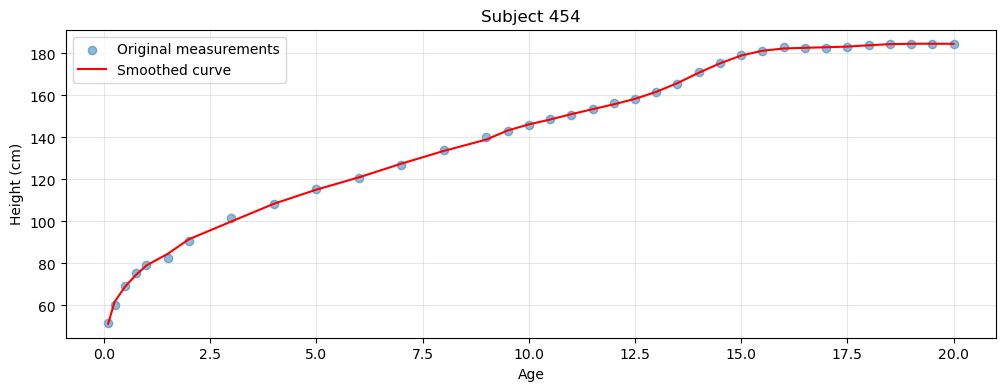

In [410]:
plot_and_save_smoothed_curve(gen1_train_smooth, id_col="gen1_id", age_col="age", subject_id=454)

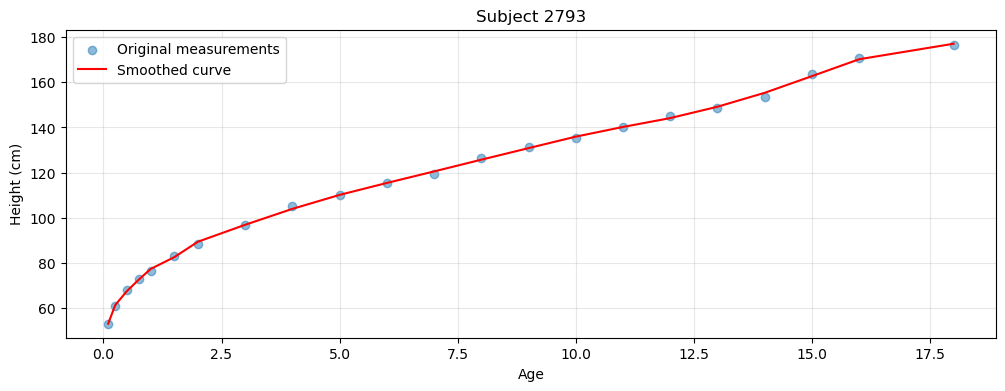

In [411]:
plot_and_save_smoothed_curve(gen2_train_smooth, id_col="gen2_id",subject_id=2793)

Parent Trajectory Reconciliation:
* Found 50 parents with children in both train and test sets
* The height differences between train/test sets are relatively small (1-1.5 cm typically)
* Handled by averaging measurements


Data Cleaning:
* Successfully removed subject 2661 (all NaN values)
* Fixed parent sex inconsistencies
* Interpolated missing values
* Dropped original columns (_orig) to keep the data clean
* Smoothed the curves

# Features

In [414]:
def compute_and_impute_velocity(df, id_col='gen2_id', age_col='AgeGr', height_col='SHgt_cm'):
    df = df.copy()
    df['height_velocity'] = df.groupby(id_col)[height_col].diff()
    df['height_velocity'] = df.groupby(age_col)['height_velocity'].transform(lambda x: x.fillna(x.mean()))
    df['height_velocity'] = df['height_velocity'].fillna(df['height_velocity'].median())
    return df

In [415]:
gen2_test_smooth=compute_and_impute_velocity(gen2_test_smooth)
gen2_train_smooth=compute_and_impute_velocity(gen2_train_smooth)
gen1_train_smooth=compute_and_impute_velocity(gen1_train_smooth, id_col="gen1_id", age_col="age", height_col="SHgt_cm")
gen1_test_smooth=compute_and_impute_velocity(gen1_test_smooth, id_col="gen1_id", age_col="age", height_col="SHgt_cm")

In [416]:
def calculate_growth_features(df, id_col, age_col, height_col='SHgt_cm', smooth_col='SHgt_cm_smooth'):
    result = df.copy()

    early_growth = []
    for _, group in result.groupby(id_col):
        early = group[group[age_col] <= 5].copy()
        if len(early) >= 2:
            growth_rate = np.polyfit(early[age_col], early[smooth_col], 1)[0]
        else:
            growth_rate = np.nan
        early_growth.extend([growth_rate] * len(group))
    result['early_growth_rate'] = early_growth
    
    result['early_growth_rate'] = result['early_growth_rate'].fillna(result['early_growth_rate'].mean())
    return result

In [417]:
def engineer_all_features(gen1_train, gen2_train, gen1_test, gen2_test):
    gen1_train = calculate_growth_features(gen1_train, 'gen1_id', 'age')
    gen2_train = calculate_growth_features(gen2_train, 'gen2_id', 'AgeGr')
    gen1_test = calculate_growth_features(gen1_test, 'gen1_id', 'age')
    gen2_test = calculate_growth_features(gen2_test, 'gen2_id', 'AgeGr')

    return gen1_train, gen2_train, gen1_test, gen2_test

In [418]:
gen1_train_features, gen2_train_features, gen1_test_features, gen2_test_features = \
    engineer_all_features(gen1_train_smooth, gen2_train_smooth, gen1_test_smooth, gen2_test_smooth)

In [419]:
for df, name in [(gen1_train_smooth, 'Gen1 Train'), 
                 (gen2_train_smooth, 'Gen2 Train')]:
    age_col = 'age' if 'age' in df.columns else 'AgeGr'
    print(f"\n{name} age distribution:")
    print(df[age_col].describe())


Gen1 Train age distribution:
count    3636.000000
mean       10.350000
std         6.324272
min         0.100000
25%         4.750000
50%        11.250000
75%        15.625000
max        20.000000
Name: age, dtype: float64

Gen2 Train age distribution:
count    4202.000000
mean        7.140909
std         5.646661
min         0.100000
25%         1.500000
50%         6.500000
75%        12.000000
max        18.000000
Name: AgeGr, dtype: float64


Gen1 (Parents):

* Good coverage from 0.1 to 20 years
* Relatively uniform distribution (mean=10.35)
* Full coverage of adult heights (up to 20 years)


Gen2 (Children):

* Coverage from 0.1 to 18 years
* More concentrated in early years (mean=7.14)
* Makes sense since we're predicting later heights

In [421]:
for df, name in [(gen1_train_features, 'Gen1 Train'), 
                 (gen2_train_features, 'Gen2 Train'),
                 (gen1_test_features, 'Gen1 Test'),
                 (gen2_test_features, 'Gen2 Test')]:
    print(f"\n{name} NaN counts:")
    print(df.isna().sum())


Gen1 Train NaN counts:
gen1_id                  0
sex_assigned_at_birth    0
age                      0
SHgt_cm                  0
SHgt_cm_smooth           0
height_velocity          0
early_growth_rate        0
dtype: int64

Gen2 Train NaN counts:
gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                    0
Wgt_kg                   198
SHgt_cm_smooth             0
height_velocity            0
early_growth_rate          0
dtype: int64

Gen1 Test NaN counts:
gen1_id                  0
sex_assigned_at_birth    0
age                      0
SHgt_cm                  0
SHgt_cm_smooth           0
height_velocity          0
early_growth_rate        0
dtype: int64

Gen2 Test NaN counts:
gen2_id                   0
sex_assigned_at_birth     0
study_parent_sex          0
study_parent_id_new       0
AgeGr                     0
SHgt_cm                   0
Wgt_kg                   56
SHg

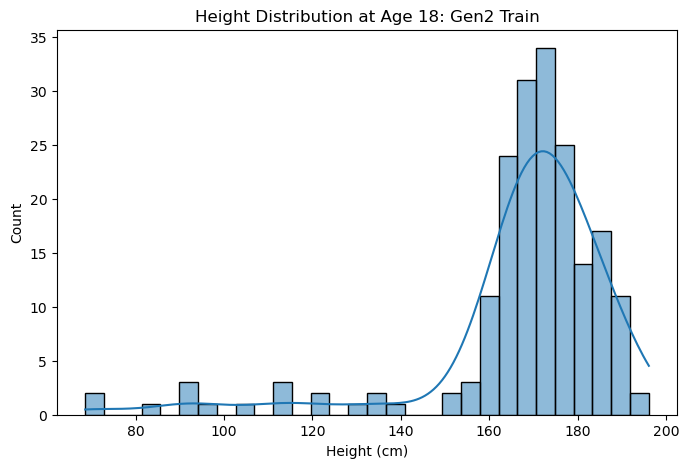

In [422]:
def plot_height_distribution_by_age(df, age_col, height_col='SHgt_cm', age_value=None, title=''):
    plt.figure(figsize=(8, 5))
    
    if age_value is not None:
        df = df[df[age_col] == age_value]
    
    sns.histplot(df[height_col], kde=True, bins=30)
    plt.title(f'Height Distribution at Age {age_value}: {title}' if age_value else f'Height Distribution: {title}')
    plt.xlabel('Height (cm)')
    plt.ylabel('Count')
    plt.savefig(f"./viz/height_distro_{title}_age_{age_value}" if age_value else f"./viz/height_distro_{title}", bbox_inches='tight')
    plt.show()

plot_height_distribution_by_age(gen2_train_smooth, age_col='AgeGr', height_col='SHgt_cm', age_value=18, title='Gen2 Train')

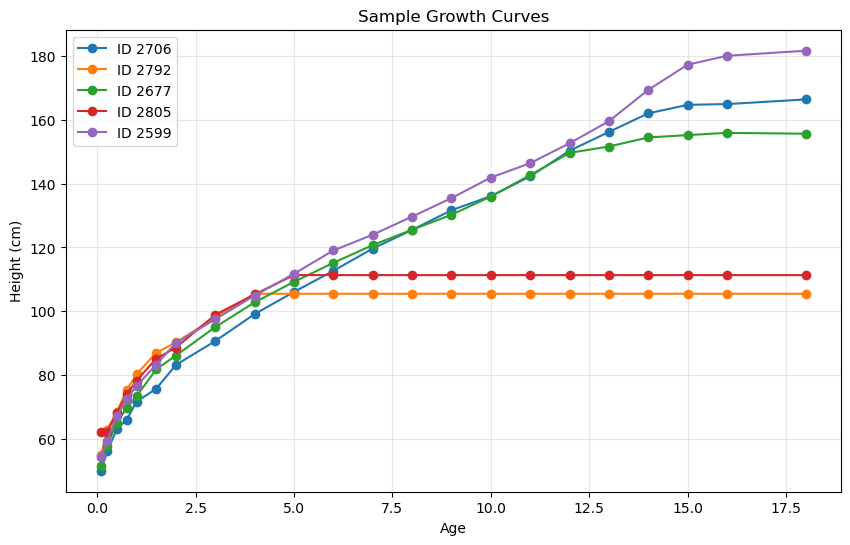

In [423]:
def plot_sample_growth_curves(df, id_col='gen2_id', age_col='AgeGr', height_col='SHgt_cm', n=5):
    sample_ids = np.random.choice(df[id_col].unique(), size=n, replace=False)
    
    plt.figure(figsize=(10, 6))
    for subject_id in sample_ids:
        subject_data = df[df[id_col] == subject_id]
        plt.plot(subject_data[age_col], subject_data[height_col], marker='o', label=f'ID {subject_id}')
    
    plt.xlabel('Age')
    plt.ylabel('Height (cm)')
    plt.title('Sample Growth Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f"./viz/sample_growth", bbox_inches='tight')
    plt.show()

plot_sample_growth_curves(gen2_train_features, n=5)

In [424]:
def compute_parent_features(gen1_train, gen2_train):
    parent_features = gen1_train.groupby('gen1_id').agg(
        max_height=('SHgt_cm', 'max'),
        age_at_max_height=('age', lambda x: x.iloc[np.argmax(x)]),
        peak_velocity=('SHgt_cm', lambda x: x.diff().max())  # max yearly growth
    ).reset_index()

    gen2_train = gen2_train.merge(parent_features, left_on='study_parent_id_new', right_on='gen1_id', how='left')

    gen2_train.drop(columns=['gen1_id'], inplace=True)
    
    return gen2_train

In [425]:
gen2_train_features = compute_parent_features(gen1_train_features, gen2_train_features)
gen2_test_features = compute_parent_features(gen1_test_features, gen2_test_features)

In [426]:
def compute_acceleration(df, id_col='gen2_id', age_col='AgeGr', height_col='SHgt_cm'):
    df = df.copy()
    df['height_acceleration'] = df.groupby(id_col)['height_velocity'].diff()
    df['height_acceleration'] = df.groupby(age_col)['height_acceleration'].transform(lambda x: x.fillna(x.mean()))
    df['height_acceleration'] = df['height_acceleration'].fillna(df['height_acceleration'].median())  # Remove inplace=True
    return df

In [427]:
gen2_train_features = compute_acceleration(gen2_train_features)
gen2_test_features = compute_acceleration(gen2_test_features)

In [428]:
def impute_missing_values_with_mice(df):
    features_to_impute = ['max_height', 'age_at_max_height', 'peak_velocity', 'height_velocity']
    
    # MICE imputer
    mice_imputer = IterativeImputer(max_iter=10, random_state=42)
    df[features_to_impute] = mice_imputer.fit_transform(df[features_to_impute])
        
    return df

gen2_train_features = impute_missing_values_with_mice(gen2_train_features)
gen2_test_features = impute_missing_values_with_mice(gen2_test_features)

In [429]:
for df, name in [(gen1_train_features, 'Gen1 Train'), 
                 (gen2_train_features, 'Gen2 Train'),
                 (gen1_test_features, 'Gen1 Test'),
                 (gen2_test_features, 'Gen2 Test')]:
    print(f"\n{name} NaN counts:")
    print(df.isna().sum())


Gen1 Train NaN counts:
gen1_id                  0
sex_assigned_at_birth    0
age                      0
SHgt_cm                  0
SHgt_cm_smooth           0
height_velocity          0
early_growth_rate        0
dtype: int64

Gen2 Train NaN counts:
gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                    0
Wgt_kg                   198
SHgt_cm_smooth             0
height_velocity            0
early_growth_rate          0
max_height                 0
age_at_max_height          0
peak_velocity              0
height_acceleration        0
dtype: int64

Gen1 Test NaN counts:
gen1_id                  0
sex_assigned_at_birth    0
age                      0
SHgt_cm                  0
SHgt_cm_smooth           0
height_velocity          0
early_growth_rate        0
dtype: int64

Gen2 Test NaN counts:
gen2_id                   0
sex_assigned_at_birth     0
study_parent_sex          0

In [430]:
def prepare_features(gen2_train_features):
    feature_cols = ['SHgt_cm', 'height_velocity', 'max_height', 'peak_velocity', 'age_at_max_height', 'height_acceleration']
    
    train_data = gen2_train_features[gen2_train_features['AgeGr'] < 10].copy()
    train_features = train_data.pivot(index='gen2_id', columns='AgeGr', values=feature_cols)
    
    train_features.columns = [f"{feat}_age{age}" for feat, age in train_features.columns]
    
    train_features = train_features.merge(
        gen2_train_features[['gen2_id', 'max_height', 'peak_velocity', 'age_at_max_height', 'height_acceleration']].drop_duplicates(),
        on='gen2_id',
        how='left'
    )

    return train_features

In [431]:
def calculate_sex_based_features(df):
    result = df.copy()
    
    result['is_female'] = (result['sex_assigned_at_birth'] == 'F').astype(int)
    
    if 'study_parent_sex' in result.columns:
        result['is_same_sex_as_parent'] = (
            ((result['sex_assigned_at_birth'] == 'F') & (result['study_parent_sex'] == 'mother')) |
            ((result['sex_assigned_at_birth'] == 'M') & (result['study_parent_sex'] == 'father'))
        ).astype(int)
        
        # sex-specific height percentiles
        result['height_percentile_sex'] = result.groupby(['sex_assigned_at_birth', 'AgeGr'])['SHgt_cm'].transform(
            lambda x: pd.Series(x).rank(pct=True)
        )
    
    return result

# Baseline Model

In [433]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [434]:
X = prepare_features(gen2_train_features)
y = gen2_train_features[gen2_train_features['AgeGr'] >= 10][['gen2_id', 'AgeGr', 'SHgt_cm']]

data = y.merge(X, on='gen2_id', how='left').drop(columns=['gen2_id'])

X_final = data.drop(columns=['SHgt_cm'])
y_final = data['SHgt_cm']

tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge(alpha=1.0)
ridge_scores = cross_val_score(ridge, X_final, y_final, cv=tscv, scoring='neg_root_mean_squared_error')
print(f"Ridge Regression Mean RMSE: {-np.mean(ridge_scores):.3f}")

lasso = Lasso(alpha=1.0)
lasso_scores = cross_val_score(lasso, X_final, y_final, cv=tscv, scoring='neg_root_mean_squared_error')
print(f"lasso Regression Mean RMSE: {-np.mean(lasso_scores):.3f}")

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_final, y_final, cv=tscv, scoring='neg_root_mean_squared_error')
print(f"Random Forest Mean RMSE: {-np.mean(rf_scores):.3f}")

Ridge Regression Mean RMSE: 8.390
lasso Regression Mean RMSE: 7.578
Random Forest Mean RMSE: 8.370


In [435]:
ridge_params = {'alpha': [0.1, 1, 10, 50, 100]}
ridge = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_root_mean_squared_error')
ridge.fit(X_final, y_final)
print(f"Best Ridge Alpha: {ridge.best_params_['alpha']} | RMSE: {-ridge.best_score_:.3f}")

lasso_params = {'alpha': [0.1, 1, 10, 50, 100]}
grid_search = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_final, y_final)
print(f"Best Lasso Alpha: {grid_search.best_params_['alpha']} | RMSE: {-grid_search.best_score_:.3f}")

Best Ridge Alpha: 100 | RMSE: 7.408


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.186e+04, tolerance: 7.411e+02
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.965e+03, tolerance: 7.696e+02
  model = cd_fast.enet_coordinate_descent(


Best Lasso Alpha: 0.1 | RMSE: 7.284


/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.792e+02, tolerance: 8.801e+02
  model = cd_fast.enet_coordinate_descent(


In [436]:
rf = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_final, y_final, cv=tscv, scoring='neg_root_mean_squared_error')
print(f"Random Forest Mean RMSE: {-np.mean(rf_scores):.3f}")

Random Forest Mean RMSE: 7.580


# Further Feature Engineering

- Identify growth spurts based on acceleration changes.
- Compute timing of key events (T2, T3, T4 for MS; T6, T8, T9 for PS).
- Extract height, velocity, and acceleration at critical points.
- Compute growth asymmetry and duration-related features.
- Merge the engineered features into your dataset.

In [439]:
from scipy.signal import argrelextrema

## 1. Mid-Growth Spurt (MS) Features
- **Age of maximum acceleration during MS (T2)**  
  The point when growth rate starts increasing significantly (avg. 6.4 years for both sexes).
  
- **Age at peak height velocity of MS (T3)**  
  The point of fastest growth in mid-childhood (avg. 7.7 years for boys, 7.5 years for girls).
  
- **Age at the end of MS (T4)**  
  The age at which the MS phase ends (slightly later for boys).
  
- **Height at T2, T3, T4**  
  The stature at these critical points of MS.
  
- **Acceleration during MS (AT2, AT3, AT4)**  
  Rate of change in height over time.
  
- **Mid-growth spurt duration (T4 - T2)**  
  Boys have a longer MS duration than girls​.
  
- **MS intensity (AT2 - AT4)**  
  Boys tend to show a stronger acceleration-deceleration cycle.

### Why these matter?
- MS can indicate prepubertal velocity trends that could affect later pubertal growth.
- The transition from MS to PS varies between sexes, which might explain growth trajectory variations.


## 2. Pubertal Spurt (PS) Features
- **Age of Peak Height Velocity (PHV, T8)**  
  Boys: ~13.9 years, Girls: ~12.2 years.  
  This is one of the strongest predictors of final height​.
  
- **Height at PHV (HT8)**  
  The stature at the peak of growth velocity.
  
- **Acceleration at PHV (AT8)**  
  Stronger acceleration means a faster growth rate during puberty.
  
- **Total pubertal spurt duration (T9 - T6)**  
  Boys have a longer growth period, leading to their taller adult height.
  
- **PS intensity (AT8 - AT9)**  
  Boys show higher acceleration, but also stronger deceleration.
  
- **Velocity drop-off after PHV (T9 - T10)**  
  How quickly the growth rate slows after peak velocity.
  
- **Height gain in PS (HT9 - HT6)**  
  Growth contribution of PS phase, typically higher for boys.

### Why these matter?
- Later PHV is negatively correlated with adult stature.
- Boys tend to have more pronounced growth acceleration-deceleration cycles.

---

# 3. Asymmetry and Growth Delays
- **Time between MS and PS (T6 - T4)**  
  Girls tend to have a shorter transition than boys, leading to an earlier pubertal peak.
  
- **Ratio of peak acceleration to peak deceleration (-AT8/AT9)**  
  This measures growth asymmetry, which is higher in girls​.
  
- **Velocity Peak Height Gain (VT8 - VT6)**  
  Boys have a higher velocity spike, leading to taller stature​.

### Why these matter?
- A strong mid-childhood acceleration followed by a long delay to PS might indicate later, taller growth.
- Asymmetry in velocity changes can highlight different growth patterns.


In [441]:
def extract_growth_features(df, id_col='gen2_id', age_col='AgeGr', height_col='SHgt_cm'):
    """Extract mid-growth spurt (MS) and pubertal spurt (PS) features"""
    feature_list = []
    
    for subject_id, data in df.groupby(id_col):
        data = data.sort_values(age_col)
        ages = data[age_col].values
        heights = data[height_col].values
        
        velocity = np.gradient(heights, ages)
        velocity[np.isnan(velocity)] = 0  # impute with 0
        
        acceleration = np.gradient(velocity, ages)
        acceleration[np.isnan(acceleration)] = 0
 
        # try to find key events in spurts
        ms_start_candidates = argrelextrema(acceleration, np.greater)[0]
        ms_end_candidates = argrelextrema(acceleration, np.less)[0]
        ps_start_candidates = argrelextrema(acceleration, np.greater)[0]
        ps_end_candidates = argrelextrema(acceleration, np.less)[0]
        
        ms_start = ages[ms_start_candidates[0]] if len(ms_start_candidates) > 0 else np.nan
        ms_peak = ages[np.argmax(velocity)] if len(velocity) > 0 else np.nan
        ms_end = ages[ms_end_candidates[0]] if len(ms_end_candidates) > 0 else np.nan
        
        ps_start = ages[ps_start_candidates[-1]] if len(ps_start_candidates) > 0 else np.nan
        ps_peak = ages[np.argmax(velocity)] if len(velocity) > 0 else np.nan
        ps_end = ages[ps_end_candidates[-1]] if len(ps_end_candidates) > 0 else np.nan
        
        # conditionally impute missing ms_start/ps_start
        if np.isnan(ms_start) and not np.isnan(ms_peak):
            ms_start = ms_peak - (np.nanmedian(ms_end - ms_peak) if not np.isnan(ms_end) else 1.5)
        if np.isnan(ps_start) and not np.isnan(ps_peak):
            ps_start = ps_peak - (np.nanmedian(ps_end - ps_peak) if not np.isnan(ps_end) else 2.0)
        
        # growth asymmetry
        min_accel_idx = np.argmin(acceleration) if len(acceleration) > 0 else None
        growth_asymmetry = (-acceleration[np.argmax(velocity)] / acceleration[min_accel_idx]
                             if min_accel_idx is not None and acceleration[min_accel_idx] != 0 else np.nan)
        if np.isnan(growth_asymmetry):
            growth_asymmetry = np.nanmedian(acceleration)  # median acceleration as fallback
        
        feature_dict = {
            id_col: subject_id,
            'ms_start': ms_start, 'ms_peak': ms_peak, 'ms_end': ms_end,
            'ps_start': ps_start, 'ps_peak': ps_peak, 'ps_end': ps_end,
            'ms_duration': ms_end - ms_start if not np.isnan(ms_start) and not np.isnan(ms_end) else np.nan,
            'ps_duration': ps_end - ps_start if not np.isnan(ps_start) and not np.isnan(ps_end) else np.nan,
            'ms_to_ps_gap': ps_start - ms_end if not np.isnan(ms_end) and not np.isnan(ps_start) else np.nan,
            'height_at_ms_peak': heights[np.argmax(velocity)] if len(velocity) > 0 else np.nan,
            'height_at_ps_peak': heights[np.argmax(velocity)] if len(velocity) > 0 else np.nan,
            'velocity_at_ms_peak': np.max(velocity) if len(velocity) > 0 else np.nan,
            'velocity_at_ps_peak': np.max(velocity) if len(velocity) > 0 else np.nan,
            'acceleration_at_ms_peak': acceleration[np.argmax(velocity)] if len(acceleration) > 0 else np.nan,
            'acceleration_at_ps_peak': acceleration[np.argmax(velocity)] if len(acceleration) > 0 else np.nan,
            'growth_asymmetry': growth_asymmetry,
        }
        
        feature_list.append(feature_dict)
    
    return pd.DataFrame(feature_list)

In [442]:
growth_features = extract_growth_features(gen2_train_features)
gen2_train = gen2_train_features.merge(growth_features, on='gen2_id', how='left')

In [443]:
growth_features = extract_growth_features(gen2_test_features)
gen2_test = gen2_test_features.merge(growth_features, on='gen2_id', how='left')

In [444]:
def add_parent_child_relationship_metrics(gen1_data, gen2_data):
    gen2_enhanced = gen2_data.copy()
    
    parent_child_metrics = []
    
    parent_groups = gen1_data.groupby('gen1_id')
    
    for child_id, child_data in gen2_data.groupby('gen2_id'):
        parent_id = child_data['study_parent_id_new'].iloc[0]
        # check if we have data for this parent
        if parent_id in parent_groups.groups:
            parent_data = parent_groups.get_group(parent_id)
            child_sex = child_data['sex_assigned_at_birth'].iloc[0]
            parent_sex = parent_data['sex_assigned_at_birth'].iloc[0]
            
            # early-to-late growth correlation in parent
            parent_early_growth = parent_data[parent_data['age'] <= 9]['SHgt_cm'].values
            parent_late_growth = parent_data[parent_data['age'] >= 10]['SHgt_cm'].values
            # only calculate if we have enough data points
            if len(parent_early_growth) >= 3 and len(parent_late_growth) >= 3:
                min_len = min(len(parent_early_growth), len(parent_late_growth))
                parent_early_late_corr = np.corrcoef(
                    parent_early_growth[:min_len], 
                    parent_late_growth[:min_len]
                )[0, 1]
            else:
                parent_early_late_corr = np.nan
            
            #parent's adult height percentile (18 is "adult")
            parent_adult_height = parent_data[parent_data['age'] >= 18]['SHgt_cm'].mean()
            
            # height at matching ages correlation
            matching_ages = []
            for child_age in child_data['AgeGr'].unique():
                # closest parent age
                closest_parent_age = parent_data['age'].iloc[
                    (parent_data['age'] - child_age).abs().argsort()[:1]
                ].values[0]
                
                # ages are reasonably close (within 0.5 year)
                if abs(child_age - closest_parent_age) <= 0.5:
                    child_height = child_data[child_data['AgeGr'] == child_age]['SHgt_cm'].iloc[0]
                    parent_height = parent_data[parent_data['age'] == closest_parent_age]['SHgt_cm'].iloc[0]
                    matching_ages.append((child_height, parent_height))
            
            # correlation if we have enough matching ages
            if len(matching_ages) >= 3:
                child_heights, parent_heights = zip(*matching_ages)
                height_age_corr = np.corrcoef(child_heights, parent_heights)[0, 1]
            else:
                height_age_corr = np.nan
            
            # growth velocity pattern similarity
            parent_velocity = parent_data.sort_values('age')['SHgt_cm'].diff().values[1:]
            child_velocity = child_data.sort_values('AgeGr')['SHgt_cm'].diff().values[1:]
            
            # use early growth for child (up to age 9)
            child_early_velocity = child_data[child_data['AgeGr'] <= 9].sort_values('AgeGr')['SHgt_cm'].diff().values[1:]
            
            # correlation between parent's full velocity and child's early velocity
            if len(child_early_velocity) >= 3 and len(parent_velocity) >= 3:
                # using first n points from parent velocity where n = length of child early velocity
                n = min(len(child_early_velocity), len(parent_velocity))
                velocity_pattern_corr = np.corrcoef(
                    child_early_velocity[:n], 
                    parent_velocity[:n]
                )[0, 1]
            else:
                velocity_pattern_corr = np.nan
            
            # parent's growth spurt timing and intensity
            if len(parent_velocity) > 0: # finding parent's peak height velocity age
                parent_phv_age = parent_data['age'].iloc[1:].iloc[np.argmax(parent_velocity)]
                parent_phv_intensity = np.max(parent_velocity)
            else:
                parent_phv_age = np.nan
                parent_phv_intensity = np.nan
            
            # parent-child height ratio at matching ages
            height_ratios = []
            for child_age in child_data['AgeGr'].unique():
                if child_age <= 9:  # only use early growth for prediction
                    closest_parent_age = parent_data['age'].iloc[
                        (parent_data['age'] - child_age).abs().argsort()[:1]
                    ].values[0]                    
                    if abs(child_age - closest_parent_age) <= 0.5:
                        child_height = child_data[child_data['AgeGr'] == child_age]['SHgt_cm'].iloc[0]
                        parent_height = parent_data[parent_data['age'] == closest_parent_age]['SHgt_cm'].iloc[0]
                        if parent_height > 0:  # Avoid division by zero
                            height_ratios.append(child_height / parent_height)
            
            mean_height_ratio = np.mean(height_ratios) if height_ratios else np.nan
            
            # expected adult height based on parent's final height and sex-specific adjustments
            # mid-parent height method with sex adjustment (approximate sex difference)
            if not np.isnan(parent_adult_height):
                if child_sex == 'M' and parent_sex == 'F':
                    # boy with mother's height: add 13cm 
                    expected_adult_height = parent_adult_height + 13
                elif child_sex == 'F' and parent_sex == 'M':
                    # girl with father's height: subtract 13cm
                    expected_adult_height = parent_adult_height - 13
                else:
                    # Same sex parent-child
                    expected_adult_height = parent_adult_height
            else:
                expected_adult_height = np.nan
            
            metrics = {
                'gen2_id': child_id,
                'parent_early_late_growth_corr': parent_early_late_corr,
                'parent_adult_height': parent_adult_height,
                'height_age_correlation': height_age_corr,
                'velocity_pattern_correlation': velocity_pattern_corr,
                'parent_phv_age': parent_phv_age,
                'parent_phv_intensity': parent_phv_intensity,
                'mean_height_ratio': mean_height_ratio,
                'expected_adult_height': expected_adult_height,
            }
            
            parent_child_metrics.append(metrics)
        
    if parent_child_metrics:
        metrics_df = pd.DataFrame(parent_child_metrics)
        
        gen2_enhanced = gen2_enhanced.merge(metrics_df, on='gen2_id', how='left')
    
    return gen2_enhanced

In [445]:
def add_missing_data_flags(df):
    """Add binary flags indicating which subjects have missing parent data."""
    df_with_flags = df.copy()
    
    parent_features = [
        'parent_early_late_growth_corr', 'parent_adult_height', 
        'height_age_correlation', 'velocity_pattern_correlation',
        'parent_phv_age', 'parent_phv_intensity', 'mean_height_ratio',
        'expected_adult_height'
    ]
    
    df_with_flags['has_parent_data'] = ~df[parent_features].isnull().any(axis=1).astype(bool)    
    for feature in parent_features:
        df_with_flags[f'{feature}_missing'] = df[feature].isnull().astype(int)
        
    return df_with_flags

In [446]:
gen2_train_enhanced = add_parent_child_relationship_metrics(gen1_train_features, gen2_train)
gen2_test_enhanced = add_parent_child_relationship_metrics(gen1_test_features, gen2_test)

In [447]:
gen2_train_flag = add_missing_data_flags(gen2_train_enhanced)
gen2_test_flag = add_missing_data_flags(gen2_test_enhanced)

In [448]:
def impute_missing_parent_features_via_clustering(df, n_clusters=4, random_state=42):
    """Impute missing parent-child features using k-means clustering."""
    df_imputed = df.copy()
    
    parent_features = [
        'parent_early_late_growth_corr', 'parent_adult_height',
        'height_age_correlation', 'velocity_pattern_correlation',
        'parent_phv_age', 'parent_phv_intensity', 'mean_height_ratio',
        'expected_adult_height'
    ]
    
    missing_mask = df['has_parent_data'] == 0    
    if not missing_mask.any():
        return df_imputed
    
    # growth features to use for clustering (early growth data)
    growth_features = [col for col in df.columns if 'SHgt_cm' in col and 'age' in col and float(col.split('age')[1]) <= 9]    
    if 'height_velocity' in df.columns:
        growth_features.append('height_velocity')
    if 'height_acceleration' in df.columns:
        growth_features.append('height_acceleration')
    if 'sex_assigned_at_birth' in df.columns:
        # dummy variable for sex
        df_imputed['sex_dummy'] = (df_imputed['sex_assigned_at_birth'] == 'M').astype(int)
        growth_features.append('sex_dummy')
    
    # only subjects with complete parent data for clustering
    complete_data = df_imputed[~missing_mask][growth_features].copy()
    # standardize
    scaler = StandardScaler()
    if len(complete_data) > 0:
        X_scaled = scaler.fit_transform(complete_data)
        # Use K-means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        cluster_labels = kmeans.fit_predict(X_scaled)
        df_imputed.loc[~missing_mask, 'cluster'] = cluster_labels
        
        # those with missing parent data, assign to the nearest cluster
        missing_data = df_imputed[missing_mask][growth_features].copy()
        if len(missing_data) > 0:
            missing_scaled = scaler.transform(missing_data)
            missing_clusters = kmeans.predict(missing_scaled)
            df_imputed.loc[missing_mask, 'cluster'] = missing_clusters
        
        # impute missing parent features based on cluster means
        for feature in parent_features:
            cluster_means = df_imputed[~missing_mask].groupby('cluster')[feature].mean()
            
            for cluster_id, mean_value in cluster_means.items():
                mask = (df_imputed['cluster'] == cluster_id) & (df_imputed[feature].isna())
                df_imputed.loc[mask, feature] = mean_value
    
    if 'sex_dummy' in df_imputed.columns:
        df_imputed.drop('sex_dummy', axis=1, inplace=True)
    if 'cluster' in df_imputed.columns:
        df_imputed.drop('cluster', axis=1, inplace=True)
    
    return df_imputed

In [449]:
gen2_train = impute_missing_parent_features_via_clustering(gen2_train_flag)
gen2_test = impute_missing_parent_features_via_clustering(gen2_test_flag)

In [450]:
gen1_train = calculate_sex_based_features(gen1_train)
gen2_train = calculate_sex_based_features(gen2_train)
gen1_test = calculate_sex_based_features(gen1_test)
gen2_test = calculate_sex_based_features(gen2_test)

In [451]:
gen2_train.isna().sum()

gen2_id                                    0
sex_assigned_at_birth                      0
study_parent_sex                           0
study_parent_id_new                        0
AgeGr                                      0
SHgt_cm                                    0
Wgt_kg                                   198
SHgt_cm_smooth                             0
height_velocity                            0
early_growth_rate                          0
max_height                                 0
age_at_max_height                          0
peak_velocity                              0
height_acceleration                        0
ms_start                                   0
ms_peak                                    0
ms_end                                     0
ps_start                                   0
ps_peak                                    0
ps_end                                     0
ms_duration                                0
ps_duration                                0
ms_to_ps_g

In [452]:
gen1_train = gen1_train_features

In [453]:
gen1_test = gen1_test_features

In [456]:
gen2_train.to_csv('./data/gen2_train.csv', index=False)
gen2_test.to_csv('./data/gen2_test.csv', index=False)
gen1_test.to_csv('./data/gen1_test.csv', index=False)
gen1_train.to_csv('./data/gen1_train.csv', index=False)